# Experimento com dados de 1 único poço

Nesse notebook será realizado as tarefas de obtenção de dados, tratamento, modelagem, e validação de dados.
O objetivo aqui é obter um classificador de anomalias para dados de 1 único poço.

A hipótese é que utilizando dados de apenas 1 poço, seja mais viável identificar padrões de anomalias.

**Dados do poço de id 5**:
- 68 normal events (979.530), 33 flow instability (271.487)
- 2 / 1 ou ( 3,6 / 1 )

Para uso nos testes preliminares de modelagem, será utilizado o poço de id 5. Motivos:
- possui boa quantidade de arquivos, e instâncias, normal e de anomalia;
- não tão desbalanceado em termos normal vs. anomalia;

In [1]:
import sys
sys.path.append("..")

# Environment configuration
import raw_data_manager.raw_data_acquisition as rda
import raw_data_manager.raw_data_inspector as rdi
import raw_data_manager.raw_data_splitter as rds
from data_exploration.metric_acquisition import MetricAcquisition
from data_preparation.transformation_manager import TransformationManager
from constants import storage_config

# Set default logging level
from absl import logging
logging.set_verbosity(logging.DEBUG)

/home/ubuntu/lemi_3w/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Aquisição de dados

Realiza o download dos dados se não estiverem já disponíveis.

In [2]:
## Acquire data (of entire 3W dataset)
rda.acquire_dataset_if_needed()
latest_converted_data_path, latest_converted_data_version = (
    rda.get_latest_local_converted_data_version(storage_config.DIR_PROJECT_DATA)
)

# Helper to overview metadata (of entire 3W dataset)
inspector_train_single_well_converted = rdi.RawDataInspector(
    latest_converted_data_path,
    storage_config.PATH_DATA_INSPECTOR_CACHE,
    True
)
metadata_train_single_well_converted = inspector_train_single_well_converted.get_metadata_table()
metadata_train_single_well_converted

INFO:absl:Directory with the biggest version: /home/ubuntu/lemi_3w/data/dataset_converted_v10101
INFO:absl:Version: 10101
INFO:absl:Latest local version is 10101
INFO:absl:Going to fetch config file from $https://raw.githubusercontent.com/petrobras/3W/main/dataset/dataset.ini
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2786  100  2786    0     0   4036      0 --:--:-- --:--:-- --:--:--  4031
INFO:absl:Latest online version is 10101
INFO:absl:Found existing converted data with dataset version of 10101
INFO:absl:Directory with the biggest version: /home/ubuntu/lemi_3w/data/dataset_converted_v10101
INFO:absl:Version: 10101


,class_type,source,well_id,path,timestamp,file_size,num_timesteps
hash_id,,,,,,,
74203bb,NORMAL,REAL,1.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-05-24 03:00:00,491415,17885
9fbd6f9,NORMAL,REAL,2.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-09 06:00:00,520154,17933
28804c5,NORMAL,REAL,6.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-05-08 09:00:31,349162,17970
42afe91,NORMAL,REAL,8.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-07-01 14:01:35,251880,17799
fa71d94,NORMAL,REAL,6.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-23 19:00:00,279737,17949
...,...,...,...,...,...,...,...
ea66cf6,SEVERE_SLUGGING,SIMULATED,NaN,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,NaT,2315903,61999
34f032a,SEVERE_SLUGGING,SIMULATED,NaN,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,NaT,2259539,61999
876a969,SEVERE_SLUGGING,REAL,14.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-09-25 06:00:42,1005717,17959


In [3]:
inspector_train_single_well_converted.get_metadata_table(well_ids=[5])

,class_type,source,well_id,path,timestamp,file_size,num_timesteps
hash_id,,,,,,,
ea7aff1,NORMAL,REAL,5.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-04-02 08:00:43,229363,17899
98bafe5,NORMAL,REAL,5.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-14 02:00:00,121535,10595
49ab511,NORMAL,REAL,5.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-17 02:00:00,174605,10747
d537387,NORMAL,REAL,5.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-14 05:00:00,158008,10685
7b40db6,NORMAL,REAL,5.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-16 20:00:00,153211,10747
...,...,...,...,...,...,...,...
403eb8c,FLOW_INSTABILITY,REAL,5.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-06-27 17:01:12,162551,7129
f589560,FLOW_INSTABILITY,REAL,5.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-06-25 06:01:03,183906,7138
a742152,FLOW_INSTABILITY,REAL,5.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-06-24 16:01:24,181359,7103


Realiza a divisão dos dados em conjuntos de treinamento, validação, e testagem.

In [4]:
selected_well_id = 5

# splits data, from the selected well, into train and test datasets
splitter = rds.RawDataSplitter(metadata_train_single_well_converted, latest_converted_data_version)
split_train_dir_single_well, split_validation_dir_single_well, split_test_dir_single_well = splitter.stratefy_split_of_data(
    data_dir=storage_config.DIR_PROJECT_DATA,
    validation_size=0.10,
    test_size=0.20,
    well_ids=[selected_well_id],
)

DEBUG:absl:validation_size 0.1
DEBUG:absl:size of train data: 83. val: 12. test: 24
DEBUG:absl:train path /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-5_train -/- val: /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-5_validation -/- test: /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-5_test
DONE: 100%|██████████| 12/12 [00:00<00:00, 152.24it/s]


Visualização da distribuição de eventos dentro de cada grupo de treinamento, validação, e testagem.

In [5]:
# generates metadata tables for split data
train_metadata_single_well = rdi.RawDataInspector(
    dataset_dir=split_train_dir_single_well,
    cache_file_path=storage_config.DIR_PROJECT_CACHE / "train_metadata_single_well.parquet",
    use_cached=False
)
validation_metadata_single_well = rdi.RawDataInspector(
    dataset_dir=split_validation_dir_single_well,
    cache_file_path=storage_config.DIR_PROJECT_CACHE / "validation_metadata_single_well.parquet",
    use_cached=False
)
test_metadata_single_well = rdi.RawDataInspector(
    dataset_dir=split_test_dir_single_well,
    cache_file_path=storage_config.DIR_PROJECT_CACHE / "test_metadata_single_well.parquet",
    use_cached=False
)

INFO:absl:Processing 57 events of class type 0.
DONE: 100%|██████████| 26/26 [00:00<00:00, 125.18it/s]
INFO:absl:Processing 0 events of class type 5.
INFO:absl:Processing 0 events of class type 1.
INFO:absl:Processing 0 events of class type 7.
INFO:absl:Processing 0 events of class type 6.
INFO:absl:Processing 0 events of class type 8.
INFO:absl:Processing 0 events of class type 2.
INFO:absl:Processing 0 events of class type 3.
INFO:absl:Found 2.
INFO:absl:Processing 8 events of class type 0.
DONE: 100%|██████████| 8/8 [00:00<00:00, 72.10it/s]
INFO:absl:Processing 4 events of class type 4.
DONE: 100%|██████████| 4/4 [00:00<00:00, 37.01it/s]
INFO:absl:Processing 0 events of class type 5.
INFO:absl:Processing 0 events of class type 1.
INFO:absl:Processing 0 events of class type 7.
INFO:absl:Processing 0 events of class type 6.
INFO:absl:Processing 0 events of class type 8.
INFO:absl:Processing 0 events of class type 2.
INFO:absl:Processing 0 events of class type 3.
INFO:absl:Found 2.
INF

In [6]:
rdi.RawDataInspector.generate_table_by_anomaly_source(train_metadata_single_well.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,57,0,0,57
ABRUPT_INCREASE_BSW,0,0,0,0
SPURIOUS_CLOSURE_DHSV,0,0,0,0
SEVERE_SLUGGING,0,0,0,0
FLOW_INSTABILITY,26,0,0,26
RAPID_PRODUCTIVITY_LOSS,0,0,0,0
QUICK_RESTRICTION_PCK,0,0,0,0
SCALING_IN_PCK,0,0,0,0
HYDRATE_IN_PRODUCTION_LINE,0,0,0,0


In [7]:
rdi.RawDataInspector.generate_table_by_anomaly_source(validation_metadata_single_well.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,8,0,0,8
ABRUPT_INCREASE_BSW,0,0,0,0
SPURIOUS_CLOSURE_DHSV,0,0,0,0
SEVERE_SLUGGING,0,0,0,0
FLOW_INSTABILITY,4,0,0,4
RAPID_PRODUCTIVITY_LOSS,0,0,0,0
QUICK_RESTRICTION_PCK,0,0,0,0
SCALING_IN_PCK,0,0,0,0
HYDRATE_IN_PRODUCTION_LINE,0,0,0,0


In [8]:
rdi.RawDataInspector.generate_table_by_anomaly_source(test_metadata_single_well.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,16,0,0,16
ABRUPT_INCREASE_BSW,0,0,0,0
SPURIOUS_CLOSURE_DHSV,0,0,0,0
SEVERE_SLUGGING,0,0,0,0
FLOW_INSTABILITY,8,0,0,8
RAPID_PRODUCTIVITY_LOSS,0,0,0,0
QUICK_RESTRICTION_PCK,0,0,0,0
SCALING_IN_PCK,0,0,0,0
HYDRATE_IN_PRODUCTION_LINE,0,0,0,0


## Processamento dos dados

Aquisição dos valores de média e desvio padrão para os dados de treinamento.

Serão usadas, essas métricas, para o processamento dos dados pela standardização.

In [9]:
# Get metrics---standard deviation and average---to be used for data transformation
cache_file_name = "one_well_metrics"

metric_aquisition = MetricAcquisition(train_metadata_single_well.get_metadata_table())
mean_and_std_metric_table = metric_aquisition.get_mean_and_std_metric(
    cache_file_name=cache_file_name,
    use_cache=False
)

mean_metric_list = mean_and_std_metric_table['mean_of_means']
std_metric_list = mean_and_std_metric_table['mean_of_stds']
mean_and_std_metric_table

DONE: 100%|██████████| 83/83 [00:00<00:00, 283.88it/s]

DONE: 100%|██████████| 83/83 [00:00<00:00, 226.15it/s]DEBUG:absl:Mean of means was adquired
    P-PDG         P-TPT       T-TPT     P-MON-CKP  T-JUS-CKP    P-JUS-CKGL  \
0     0.0  2.084315e+07  105.692047  1.173802e+07  65.322830  2.036077e+09   
1     0.0  2.083865e+07  105.745826  1.174302e+07  65.706947  2.007084e+09   
2     0.0  2.083736e+07  105.741728  1.174040e+07  65.711567  2.017208e+09   
3     0.0  2.086246e+07  105.780652  1.174795e+07  65.416562  2.024063e+09   
4     0.0  2.096603e+07  105.711266  1.191365e+07  64.620484  1.945122e+09   
..    ...           ...         ...           ...        ...           ...   
78    0.0  2.077091e+07  106.046780  1.158828e+07  66.506889  3.559631e+05   
79    0.0  2.079241e+07  106.173477  1.159337e+07  66.413435  3.466817e+05   
80    0.0  2.078499e+07  106.059216  1.158694e+07  66.402377  8.138856e+07   
81    0.0  2.078783e+07  106.187020  1.158364e+07  66.584210  3.089713e+05   
82    0.0  2.080075e+07  106.207412  1.161568e+07 

,mean_of_means,mean_of_stds
P-PDG,0.000000e+00,0.000000e+00
P-TPT,2.084892e+07,6.126515e+04
T-TPT,1.059528e+02,2.751405e-01
P-MON-CKP,1.169747e+07,1.664907e+05
T-JUS-CKP,6.589911e+01,9.480345e-01
P-JUS-CKGL,1.271677e+09,7.192942e+08
QGL,NaN,0.000000e+00


A lista de variáveis escolhidas foi elaborada para remover colunas de dados nulos, sem informação.

In [10]:
selected_variables = ["P-TPT", "T-TPT", "P-MON-CKP", "T-JUS-CKP", "P-JUS-CKGL", "class"]

transformation_param_sample_interval_seconds = 60
transformation_param_num_timesteps_for_window = 20

Para cada evento é aplicado uma série de etapas de processamento em seus dados.

In [11]:
tranformed_train_folder_name = split_train_dir_single_well.name
transformation_manager_single_well_train = TransformationManager(
    train_metadata_single_well.get_metadata_table(), 
    output_folder_base_name=tranformed_train_folder_name
)

transformation_manager_single_well_train.apply_transformations_to_table(
    output_parent_dir=storage_config.DIR_PROJECT_DATA,
    selected_variables = selected_variables,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DEBUG:absl:TransformationManager initialized with 83 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-5_train.
DONE: 100%|██████████| 83/83 [00:01<00:00, 62.30it/s]


In [12]:
tranformed_validation_folder_name = split_validation_dir_single_well.name
transformation_manager_single_well_validation = TransformationManager(
    validation_metadata_single_well.get_metadata_table(), 
    output_folder_base_name=tranformed_validation_folder_name
)


transformation_manager_single_well_validation.apply_transformations_to_table(
    output_parent_dir=storage_config.DIR_PROJECT_DATA,
    selected_variables = selected_variables,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DEBUG:absl:TransformationManager initialized with 12 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-5_validation.
DONE: 100%|██████████| 12/12 [00:00<00:00, 38.28it/s]


In [13]:
tranformed_test_folder_name = split_test_dir_single_well.name
transformation_manager_single_well_test = TransformationManager(
    test_metadata_single_well.get_metadata_table(), 
    output_folder_base_name=tranformed_test_folder_name
)


transformation_manager_single_well_test.apply_transformations_to_table(
    output_parent_dir=storage_config.DIR_PROJECT_DATA,
    selected_variables = selected_variables,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DEBUG:absl:TransformationManager initialized with 24 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-5_test.
DONE: 100%|██████████| 24/24 [00:00<00:00, 42.67it/s]


In [14]:
import pathlib, os

path = pathlib.Path(os.getcwd()).parent / "data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-5_train/0/WELL-00005_20170331110000.npz"
X, y = TransformationManager.retrieve_pair_array(path)
X[0]

array([[-0.60606143,  1.51035358, -0.95061749,  1.33723666,  0.07728838],
       [-0.59394198,  1.51315821, -0.93595301,  1.3367089 ,  0.07810179],
       [-0.60079471,  1.50166711, -0.94886064,  1.33618184,  0.07749268],
       [-0.55955321,  1.51751356, -0.94203843,  1.33565444,  0.0772843 ],
       [-0.52577108,  1.51909457, -0.96295151,  1.33512703,  0.07703454],
       [-0.56814972,  1.50733694, -0.95996436,  1.33459962,  0.0774661 ],
       [-0.54339394,  1.49933497, -0.95775903,  1.33407204,  0.07612235],
       [-0.53521365,  1.50933592, -0.95610128,  1.33354481,  0.07791339],
       [-0.57540779,  1.52109355, -0.96421485,  1.3330174 ,  0.07763108],
       [-0.54076601,  1.50757924, -0.95018203,  1.33249   ,  0.07698039],
       [-0.52894853,  1.49706946, -0.96145994,  1.33196259,  0.07670857],
       [-0.56399292,  1.49784482, -0.97143847,  1.33143518,  0.07691519],
       [-0.57264657,  1.5052471 , -0.96584757,  1.33090742,  0.07753228],
       [-0.55504548,  1.51491489, -0.9

# Modelagem

In [15]:
from tensorflow import keras, math
import keras_tuner
import numpy as np

from raw_data_manager.models import EventClassType

2023-10-13 13:28:47.948449: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 13:28:47.954315: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 13:28:48.011718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-13 13:28:48.011821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-13 13:28:48.011895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Using TensorFlow backend


In [16]:
# Get transformed files paths
TRANSFORMATION_NAME_PREFIX = "transform-isdt-"
tranformed_train_single_well_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + tranformed_train_folder_name)
tranformed_validation_single_well_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + tranformed_validation_folder_name)
tranformed_test_single_well_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + tranformed_test_folder_name)

# Generate inspectors for the transformed data
inspector_train_single_well_converted = rdi.RawDataInspector(
    tranformed_train_single_well_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "single_well_transformed-train.parquet",
    use_cached=False
)
inspector_validation_single_well_transformed = rdi.RawDataInspector(
    tranformed_validation_single_well_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "single_well_transformed-validation.parquet",
    use_cached=False
)
inspector_test_single_well_transformed = rdi.RawDataInspector(
    tranformed_test_single_well_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "single_well_transformed-test.parquet",
    use_cached=False
)

# Get list of paths for the events in each of the data groups (train, val, test)
metadata_train_single_well_converted = inspector_train_single_well_converted.get_metadata_table()
transformed_train_data_single_well_file_path_list = metadata_train_single_well_converted["path"]

metadata_validation_single_well_transformed = inspector_validation_single_well_transformed.get_metadata_table()
transformed_validation_data_single_well_file_path_list = metadata_validation_single_well_transformed["path"]

metadata_test_single_well_transformed = inspector_test_single_well_transformed.get_metadata_table()
transformed_test_data_single_well_file_path_list = metadata_test_single_well_transformed["path"]

INFO:absl:Processing 65 events of class type 0.
DONE: 100%|██████████| 65/65 [00:00<00:00, 502.44it/s]INFO:absl:Processing 30 events of class type 4.

DONE: 100%|██████████| 30/30 [00:00<00:00, 362.24it/s]
INFO:absl:Processing 0 events of class type 5.
INFO:absl:Processing 0 events of class type 1.
INFO:absl:Processing 0 events of class type 7.
INFO:absl:Processing 0 events of class type 6.
INFO:absl:Processing 0 events of class type 8.
INFO:absl:Processing 0 events of class type 2.
INFO:absl:Processing 0 events of class type 3.
INFO:absl:Found 2.
INFO:absl:Processing 8 events of class type 0.
DONE: 100%|██████████| 8/8 [00:00<00:00, 82.24it/s]INFO:absl:Processing 4 events of class type 4.

DONE: 100%|██████████| 4/4 [00:00<00:00, 45.11it/s]
INFO:absl:Processing 0 events of class type 5.
INFO:absl:Processing 0 events of class type 1.
INFO:absl:Processing 0 events of class type 7.
INFO:absl:Processing 0 events of class type 6.
INFO:absl:Processing 0 events of class type 8.
INFO:absl:Pro

Funções que acessam os dados transformados, os retornando através de geradores.

Uteis para retornar os dados em batches de informação.

Evitando assim problemas de excesso de uso de memória ao tentar retornar toda a informação de uma vez.

In [17]:
def data_generator_loop(file_path_list):
    """Generator returning batches of data for each file path"""
    while True:
        for file_path in file_path_list:
            X, y = TransformationManager.retrieve_pair_array(pathlib.Path(file_path))
            yield X, y

def data_generator_non_loop(file_path_list):
    """Generator returning batches of data for each file path"""
    
    for file_path in file_path_list:
        X, y = TransformationManager.retrieve_pair_array(pathlib.Path(file_path))
        yield (X, y)

### Determinação de melhores parâmetros

Estruturação do modelo.

In [20]:
num_features = X.shape[2]
num_outputs = len(EventClassType)

def build_model(hp: keras_tuner.HyperParameters):
    # model structure
    model = keras.Sequential()

    model.add(keras.layers.LSTM(
        hp.Int('lstm_units', min_value=5, max_value=100, step=5), 
        activation='relu', 
        input_shape=(transformation_param_num_timesteps_for_window, num_features)))
    
    if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Dense(
        hp.Int('dense_units', min_value=20, max_value=200, step=10),
        activation='relu'))
    
    model.add(keras.layers.Dense(num_outputs, activation='softmax'))

    # compiling model
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
        metrics=['accuracy'],
    )
    return model

# check the model can compile
build_model(keras_tuner.HyperParameters())

Procurar melhores hyperparâmetros de treinamento.

In [21]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory=storage_config.DIR_PROJECT_DATA / "keras_tuner",
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 100, 'step': 5, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 10, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [22]:
num_epochs = 10
steps_per_epoch = len(transformed_train_data_single_well_file_path_list)

train_data_gen = data_generator_loop(transformed_train_data_single_well_file_path_list)
validation_data_gen = data_generator_loop(transformed_train_data_single_well_file_path_list)
test_data_gen = data_generator_loop(transformed_train_data_single_well_file_path_list)

tuner.search(
    train_data_gen,
    epochs=num_epochs,
    validation_data=validation_data_gen,
    validation_steps=len(transformed_validation_data_single_well_file_path_list),
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

Trial 5 Complete [00h 00m 13s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 01m 56s


In [23]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                15840     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 180)               10980     
                                                                 
 dense_1 (Dense)             (None, 9)                 1629      
                                                                 
Total params: 28449 (111.13 KB)
Trainable params: 28449 (111.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Treinamento do modelo.

In [18]:
# num_epochs = 15
# # times the generator (data_gen) should be called to complete one full pass through your training dataset
# steps_per_epoch = len(transformed_train_data_single_well_file_path_list)


# train_data_gen = data_generator_loop(transformed_train_data_single_well_file_path_list)
# validation_data_gen = data_generator_loop(transformed_train_data_single_well_file_path_list)
# test_data_gen = data_generator_loop(transformed_train_data_single_well_file_path_list)


# # Train the model
# model.fit(
#     train_data_gen,
#     validation_data=validation_data_gen,
#     validation_steps=len(transformed_train_data_single_well_file_path_list),
#     steps_per_epoch=steps_per_epoch,
#     epochs=num_epochs, 
#     verbose=1
# )

Epoch 1/15


95/95 [==============================] - 4s 24ms/step - loss: 1.6465 - accuracy: 0.7221 - val_loss: 0.3745 - val_accuracy: 0.9931
Epoch 2/15
95/95 [==============================] - 2s 22ms/step - loss: 0.1204 - accuracy: 0.9820 - val_loss: 35.9090 - val_accuracy: 0.6787
Epoch 3/15
95/95 [==============================] - 2s 20ms/step - loss: 1.7465 - accuracy: 0.9230 - val_loss: 0.1738 - val_accuracy: 0.9931
Epoch 4/15
95/95 [==============================] - 2s 20ms/step - loss: 0.1665 - accuracy: 0.9909 - val_loss: 0.0981 - val_accuracy: 0.9931
Epoch 5/15
95/95 [==============================] - 2s 20ms/step - loss: 0.1047 - accuracy: 0.9918 - val_loss: 0.0567 - val_accuracy: 0.9931
Epoch 6/15
95/95 [==============================] - 2s 21ms/step - loss: 0.0680 - accuracy: 0.9920 - val_loss: 0.0349 - val_accuracy: 0.9931
Epoch 7/15
95/95 [==============================] - 2s 19ms/step - loss: 0.0466 - accuracy: 0.9929 - val_loss: 0.0243 - val_accuracy: 0.9931
Epoch 8/15
95/95 [=====

Verificar a saída do modelo para uma dada entrada.

In [19]:
# test_file = transformed_train_data_single_well_file_path_list[-1]
# print(test_file)

# Xhat, yhat = TransformationManager.retrieve_pair_array(pathlib.Path(test_file))
# print(f"True value: {yhat[0]}")

# Xhat0 = Xhat[0].reshape(1, transformation_param_num_timesteps_for_window, num_features)
# print(f"Predicted value: {model.predict(Xhat0)}")

/home/ubuntu/lemi_3w/data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-5_train/4/WELL-00005_20170624060038.npz
True value: [0 0 0 0 1 0 0 0 0]


1/1 [==============================] - 0s 226ms/step
Predicted value: [[0. 0. 0. 0. 1. 0. 0. 0. 0.]]


# Validação

Verificar a perfomance do nosso modelo.

Verificar a acurácia.

In [24]:
num_steps = len(transformed_test_data_single_well_file_path_list)

best_model.evaluate(
    data_generator_non_loop(transformed_test_data_single_well_file_path_list),
    verbose=1,
    steps=num_steps,
)

24/24 [==============================] - 1s 9ms/step - loss: 0.9106 - accuracy: 1.0000


[0.9105536937713623, 1.0]

Obter lista de predições do modelo e lista das labels, para conferir as predições.

In [25]:
# Get model's predictions
y_test_predictions = best_model.predict(
    data_generator_non_loop(transformed_test_data_single_well_file_path_list)
)
f"Number of predictions: {len(y_test_predictions)}", f"Shape of y array: {y_test_predictions.shape}", y_test_predictions[0]

# Get ground truth
y_test_labels = []
for X, y in data_generator_non_loop(transformed_test_data_single_well_file_path_list):
    y_test_labels.append(y)
y_test_labels = np.concatenate(y_test_labels, axis=0)
f"Number of predictions: {len(y_test_labels)}", f"Shape of y array: {y_test_labels.shape}", y_test_labels[0]

24/24 [==============================] - 1s 12ms/step


('Number of predictions: 3962',
 'Shape of y array: (3962, 9)',
 array([1, 0, 0, 0, 0, 0, 0, 0, 0]))

Montagem de uma matriz de confusão, para visualizar a performance do modelo.

In [26]:
y_test_labels_1d = np.argmax(y_test_labels, axis=1)
y_test_predictions_1d = np.argmax(y_test_predictions, axis=1)

math.confusion_matrix(
    y_test_labels_1d,
    y_test_predictions_1d,
    num_classes=num_outputs,
)

<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[3155,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,  807,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)>

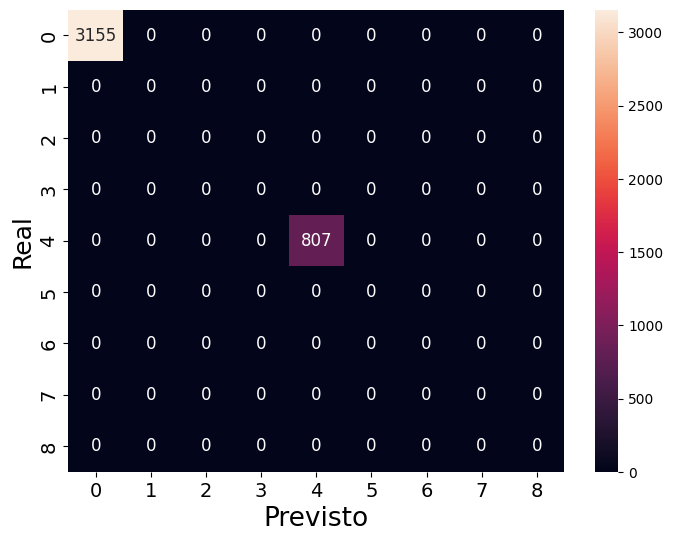

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from raw_data_manager.models import EventClassType

consusion_array = np.array([[3155,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,  807,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]],)

fig, ax = plt.subplots(figsize=(8,6))
heatmap = sns.heatmap(consusion_array, annot=True, fmt='d', xticklabels=[e.value for e in EventClassType], yticklabels=[e.value for e in EventClassType], annot_kws={"size": 12})
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 14)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 14)


plt.ylabel('Real', fontsize=18)
plt.xlabel('Previsto', fontsize=19)
plt.show()

